## Step0.1 - EDA

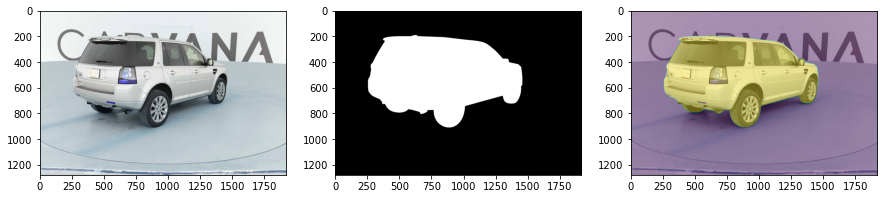

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random

def rle_decode(mask_rle, shape=(1280, 1918)):
    '''
    mask_rle 格式:
        starts: 879386, 881253, 883140, ...
        lengths: 40, 141, 205, ...
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255 # 方便后续ToTensor
    return img.reshape(shape) # reshape成原始大小(1280, 1918)

cwd = os.path.abspath('.')
bPath = os.path.abspath('./input')
rle_csv = pd.read_csv(os.path.abspath('./input/train_masks.csv'))
'''
print(rle_csv.head())
                   img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
'''

imgs = rle_csv['img']
rle_masks = rle_csv['rle_mask']

idx = random.randint(0, len(imgs))
si, sm = imgs[idx], rle_masks[idx]
si = os.path.join(bPath, 'train', si)

fig, axes = plt.subplots(1, 3, figsize=(15, 40))
axes[0].imshow(cv2.imread(si))
axes[1].imshow(rle_decode(sm), cmap='gray')
axes[2].imshow(cv2.imread(si))
axes[2].imshow(rle_decode(sm), alpha=0.4)
plt.show()

## Step0.2 - Utils

In [25]:
import os
import sys
import time

TOTAL_BAR_LENGTH = 30
last_time = time.time()
begin_time = last_time

def progress_bar(current, total, msg):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write('[')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('Step:%s' % format_time(step_time))
    L.append(' | Tot:%s' % format_time(tot_time))
    L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    
    for i in range(5):
        sys.stdout.write(' ')

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

## Step1 - Make Masks

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random
from PIL import Image
from tqdm import tqdm

maskPath = os.path.join(bPath, 'train_masks_own')
if os.path.isdir(maskPath):
    print("train masks are already available")
else:
    os.mkdir(maskPath)
    rle_csv = pd.read_csv(os.path.join(bPath, 'train_masks.csv'))
    imgNames = [img.split('.')[0] for img in rle_csv['img']]

    for name, rle in tqdm(zip(imgNames, rle_csv['rle_mask'])):
        mask_img = rle_decode(rle)
        mask_img_name = os.path.join(maskPath, name+'_mask.jpg')
        cv2.imwrite(mask_img_name, mask_img)

5088it [00:52, 96.43it/s]


## Step2 - Get mean and std of dataset

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

def get_mean_and_std(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for inputs, _ in tqdm(dataloader):
        for i in range(3):
            # 累计3个通道
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

tmp_dir = os.path.join(cwd, '/input/imagefolder')
train_transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.ImageFolder(data_dir, transform=train_transform)

print(get_mean_and_std(trainset))
# TODO: fixbug @yiw, we should calculate all the dataset, not only train dataset
# (tensor([0.6982, 0.6909, 0.6840]), tensor([0.2327, 0.2369, 0.2345]))

100%|██████████| 5088/5088 [02:35<00:00, 32.74it/s]

(tensor([0.6982, 0.6909, 0.6840]), tensor([0.2327, 0.2369, 0.2345]))


## Step3 - Define transformation

In [7]:
import cv2
import random
import math
import numpy as np
from PIL import Image
from torchvision import transforms

class RandomHorizontalFlip(object):
    def __call__(self, images):
        assert isinstance(images, list)
        if random.random() < 0.5:
            return map(lambda x: x.transpose(Image.FLIP_LEFT_RIGHT), images)
        return images

class Rescale(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, image):
        if self.size == image.size:
            return image
        else:
            image = image.resize(self.size, self.interpolation)
        return image

def random_shift_scale_rotate(images, shift_limit=(-0.0625, 0.0625), scale_limit=(1/1.1, 1.1),
                              rotate_limit=(-7, 7), aspect_limit=(-1, 1), borderMode=cv2.BORDER_REFLECT_101,
                              u=0.5):
    assert isinstance(images, list)

    images[1] = images[1].reshape(images[1].shape + (1,))

    if random.random() < u:
        height, width, channel = images[0].shape

        angle = random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = random.uniform(scale_limit[0], scale_limit[1])
        aspect = random.uniform(aspect_limit[0], aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = math.cos(angle / 180 * math.pi) * (sx)
        ss = math.sin(angle / 180 * math.pi) * (sy)
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)

        for i, image in enumerate(images):
            images[i] = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR,
                                     borderMode=borderMode)
    return images

def random_brightness(image, limit=(-0.3, 0.3), u=0.5):
    assert image.max() <= 1.0
    if random.random() < u:
        alpha = 1.0 + random.uniform(limit[0], limit[1])
        image = alpha * image
        image = np.clip(image, 0., 1.)
    return image

def random_contrast(image, limit=(-0.3, 0.3), u=0.5):
    if random.random() < u:
        alpha = 1.0 + random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])
        gray = image * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        image = alpha * image + gray
        image = np.clip(image, 0., 1.)
    return image

def random_saturation(image, limit=(-0.3, 0.3), u=0.5):
    if random.random() < u:
        alpha = 1.0 + random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])
        gray = image * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        image = alpha * image + (1.0 - alpha) * gray
        image = np.clip(image, 0., 1.)
    return image

def random_hue(image, hue_limit=(-0.1, 0.1), u=0.5):
    if random.random() < u:
        h = int(random.uniform(hue_limit[0], hue_limit[1]) * 180)
        image = (image * 255).astype(np.uint8)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:, :, 0] = (hsv[:, :, 0].astype(int) + h) % 180
        image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR).astype(np.float32) / 255
    return image

class TrainTransform:
    def __init__(self, new_size):
        self.resize = Rescale(new_size)
        self.flip = RandomHorizontalFlip()
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.6982, 0.6909, 0.6840], std=[0.2327, 0.2369, 0.2345])
    
    def __call__(self, image, mask):
        image = self.resize(image)
        mask = self.resize(mask)
        image, mask = self.flip([image, mask])
        image = np.array(image, dtype=np.float32)
        image = image / 255.0
        image = random_brightness(image, limit=(-0.5, 0.5), u=0.5)
        image = random_contrast(image, limit=(-0.5, 0.5), u=0.5)
        image = random_saturation(image, limit=(-0.3, 0.3), u=0.5)
        image = np.asarray(image * 255, dtype=np.uint8)
        image, mask = self.to_tensor(image), self.to_tensor(mask)
        image = self.normalize(image)
        return image, mask

## Step4 - Dataset

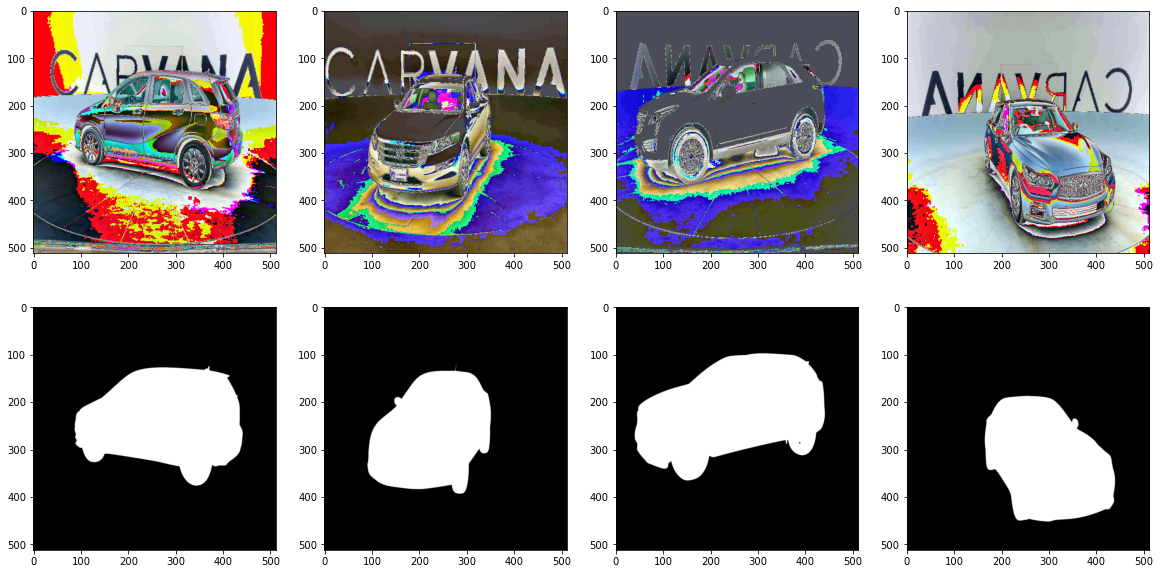

In [17]:
import os
import sys
import cv2
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# 1. use PIL Image（PyTorch官方指定） rather than cv2.imread
# 2. masks should not be normalized
DEBUG = False

class CarvanaDataset(Dataset):
    def __init__(self, images_path, masks_path=None, transform=None, train=True):
        self.images_path = images_path
        self.images = os.listdir(images_path)
        if train:
            self.train = True
            self.masks_path = masks_path
            self.masks = os.listdir(masks_path)
            self.transform = transform
        else:
            self.train = False
            self.transform = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.6982, 0.6909, 0.6840], std=[0.2327, 0.2369, 0.2345])
            ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.train:
            img_path = os.path.join(self.images_path, self.images[idx])
            car_img = Image.open(img_path)
            img_id = self.images[idx].split('.')[0]
            mask_path = os.path.join(self.masks_path, img_id+'_mask.jpg')
            car_mask = Image.open(mask_path)
            if DEBUG:
                import matplotlib.pyplot as plt
                fig, axes = plt.subplots(1, 2, figsize=(10, 20))
                axes[0].imshow(car_img)
                axes[1].imshow(car_mask)
                plt.show()
            if self.transform != None:
                car_img, car_mask = self.transform(car_img, car_mask)
            return car_img, car_mask
        else:
            img_path = os.path.join(self.images_path, self.images[idx])
            car_img = Image.open(img_path)
            img_id = self.images[idx].split('.')[0]
            car_img = self.transform(car_img)
        return car_img, img_id

def test():
    train_set = CarvanaDataset(images_path=os.path.abspath('./input/train'),
                               masks_path=os.path.abspath('./input/train_masks_own'),
                               transform=TrainTransform(new_size=(512, 512)))
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=4, shuffle=True, num_workers=4)
    sample_images, sample_masks = next(iter(train_loader))

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    for i in range(4):
        axes[0][i].imshow(transforms.ToPILImage()(sample_images[i, ...]).convert('RGB'))
        axes[1][i].imshow(sample_masks[i,0,...], cmap='gray')
    plt.show()

if __name__ == '__main__':
    test()

## Step5 - UNet

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.input = DoubleConv(n_channels, 64)
        
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.output = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.input(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.output(x)
        return logits

if __name__ == "__main__":
    net = UNet(n_channels=3, n_classes=1).to('cuda')
    print(net)
    summary(net, (3, 512, 512))

UNet(
  (input): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mome

## Step6 - Define Losses

In [19]:
import torch
import torch.nn as nn

def dice_ceff(y_pred, y_gt):
    probs = torch.sigmoid(y_pred)
    num = y_gt.size(0)
    predicts = (probs.view(num, -1) > 0.5).float()
    y_gt = y_gt.view(num, -1)
    intersection = predicts * y_gt
    score = (2.0 * intersection.sum(1)) / (predicts.sum(1) + y_gt.sum(1))
    return score.mean()

def dice_loss(y_pred, y_gt):
    return 1 - dice_ceff(y_pred, y_gt)

def bce_dice_loss(y_pred, y_gt):
    bceL = nn.BCEWithLogitsLoss()(y_pred.view(-1), y_gt.view(-1))
    diceL = dice_loss(y_pred, y_gt)
    return bceL + diceL

## Step7 - Train UNet

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import os
import sys
import argparse

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_loss = float('inf')
start_epoch = 0

print("==> Preparing data...")
cwd = os.path.abspath('.')
full_dataset = CarvanaDataset(images_path=os.path.join(cwd, 'input/train'),
                               masks_path=os.path.join(cwd, 'input/train_masks_own'),
                               transform=TrainTransform(new_size=(256, 256)))
train_size = int(0.8 * len(full_dataset))
validate_size = len(full_dataset) - train_size

train_set, validate_set = torch.utils.data.random_split(full_dataset, [train_size, validate_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=1)
validate_loader = torch.utils.data.DataLoader(validate_set, batch_size=8, num_workers=1)

# Model
print("==> Building model...")
net = UNet(n_channels=3, n_classes=1)
net = net.to(device)

criterion = bce_dice_loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Training
def train(epoch):
    net.train()
    train_loss = 0.
    
    for batch_idx, (inputs, masks) in enumerate(train_loader):
        inputs, masks = inputs.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = net(inputs)
        loss = criterion(y_pred, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        progress_bar(batch_idx, len(train_loader), 'Train Loss:%.3f | Dice Coef:%.3f'
                     % (train_loss / (batch_idx+1), dice_ceff(y_pred, masks)))

def validate(epoch):
    net.eval()
    test_loss = 0.
    global best_loss

    with torch.no_grad():
        for batch_idx, (inputs, masks) in enumerate(validate_loader):
            inputs, masks = inputs.to(device), masks.to(device)
            y_pred = net(inputs)
            loss = criterion(y_pred, masks)

            test_loss += loss.item()
            progress_bar(batch_idx, len(validate_loader), 'Val Loss:%.3f | Dice Coef:%.3f'
                     % (test_loss / (batch_idx+1), dice_ceff(y_pred, masks)))
            
        if test_loss/(batch_idx+1) < best_loss:
            best_loss = test_loss / (batch_idx+1)
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            print('Saving model...')
            state = {
                'net': net.state_dict(),
                'loss': best_loss,
                'epoch': epoch
            }
            torch.save(state, 'checkpoint/carvana-unet.pth')

for epoch in range(start_epoch, start_epoch+20):
    print('\nEpoch: %d' % epoch)
    train(epoch)
    validate(epoch)

==> Preparing data...
==> Building model...

Epoch: 0
[=============================>]Step:171ms | Tot:2m20s | Train Loss:0.390 | Dice Coef:0.964        
[=============================>]Step:24ms | Tot:34s577ms | Val Loss:0.156 | Dice Coef:0.958      
Saving model...

Epoch: 1
[=============================>]Step:171ms | Tot:2m20s | Train Loss:0.095 | Dice Coef:0.969        
[=============================>]Step:24ms | Tot:34s636ms | Val Loss:0.084 | Dice Coef:0.966      
Saving model...

Epoch: 2
[=============================>]Step:171ms | Tot:2m21s | Train Loss:0.065 | Dice Coef:0.978        
[=============================>]Step:24ms | Tot:34s567ms | Val Loss:0.070 | Dice Coef:0.970      
Saving model...

Epoch: 3
[=============================>]Step:172ms | Tot:2m21s | Train Loss:0.053 | Dice Coef:0.979        
[=============================>]Step:24ms | Tot:34s618ms | Val Loss:0.050 | Dice Coef:0.982      
Saving model...

Epoch: 4
[=============================>]Step:172ms | Tot:2

## Step8 - Predict and Submit

In [29]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision import datasets, transforms

original_shape = (1280, 1918)
threshold = 0.5
test_dataset = CarvanaDataset(images_path=os.path.join(cwd, 'input/test/'), train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

checkpoint = torch.load(os.path.join(cwd, 'checkpoint/carvana-unet.pth'))
net = UNet(n_channels=3, n_classes=1).to('cuda')
net.load_state_dict(checkpoint['net'])
net.eval()

def rle_encode(mask):
    '''
    mask: numpy array, 1 - foreground, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle

with torch.no_grad():
    result_dict = {}
    result_dict['img'] = []
    result_dict['rle_mask'] = []
    for i, (inputs, image_ids) in tqdm(enumerate(test_loader), total=len(test_loader)):
        inputs = inputs.to('cuda')
        
        outputs = net(inputs)
        outputs = F.upsample(outputs, size=original_shape, mode='bilinear')
        output_probs = torch.sigmoid(outputs)
        masks = (output_probs > threshold).data.cpu().numpy()
        
        masks = np.squeeze(masks)
        for mask, image_id in zip(masks, image_ids):
            rle = rle_encode(mask)
            result_dict['img'].append(f'{image_id}.jpg')
            result_dict['rle_mask'].append(rle)

result_df = pd.DataFrame(data=result_dict)
result_df.to_csv('./submission.csv', index=None)

100%|██████████| 25016/25016 [22:23<00:00, 18.62it/s]


## Step9 - Visualization

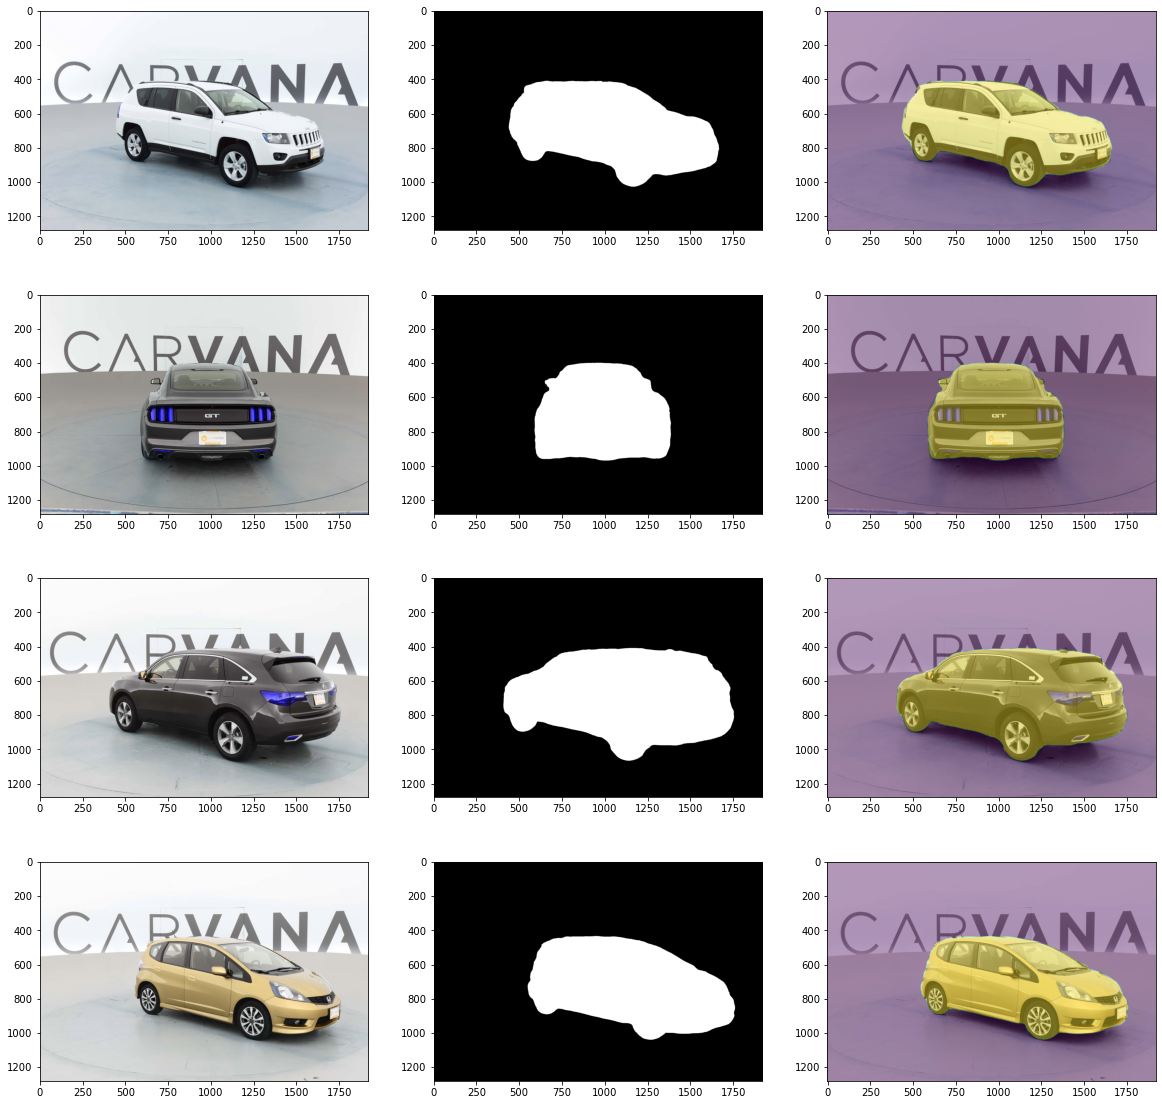

In [42]:
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

test_dataset = CarvanaDataset(images_path=os.path.join(cwd, 'input/test/'), train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=1)

fig, axes = plt.subplots(4, 3, figsize=(20, 20))
test_path = os.path.join(cwd, 'input/test')
for _, filenames in test_loader:
    for i in range(4):
        filename = os.path.join(test_path, f'{filenames[i]}.jpg')
        axes[i][0].imshow(cv2.imread(filename))
        rle = result_df.loc[result_df['img'] == f'{filenames[i]}.jpg']['rle_mask'].item()
        axes[i][1].imshow(rle_decode(rle), cmap='gray')
        axes[i][2].imshow(cv2.imread(filename))
        axes[i][2].imshow(rle_decode(rle), alpha=0.4)
    break
plt.show()